In [1]:
# Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install tensorflow

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import datetime
import time
import math
import warnings

warnings.filterwarnings("ignore")
import glob

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
import time

In [2]:
# max_rows = 44640  #31 days
max_rows = 406748  #283 days

# df1_train = df[1].loc[:dates[1][15]]
# df1_val = df[1].loc[dates[1][15]:dates[1][17]]
# df1_test = df[1].loc[dates[1][17]:]
df1_train_max = 200
df1_val_max = 219
df1_test_min = 220

In [3]:
def read_house_data(house):
    # path = '/kaggle/input/pakistan-residential-electricity-consumption/House{}.csv'.format(house)
    path = 'precon_dataset/House{}.csv'.format(house)
    df = pd.read_csv(path)
    df['Date_Time'] = df['Date_Time'].astype("datetime64[s]")
    df = df.set_index(df['Date_Time'].values)
    df.drop(['Date_Time'], axis=1, inplace=True)
    return df


df = {}
# for i in range(1,10):
#     df[i] = read_house_data(i)


# Hosue 4 and 9
df[1] = read_house_data(4)
df1_mains2 = df[1].iloc[:, 1:].sum(axis=1)
# df[1].insert(loc = 1,column = 'Sum_kW',value = df1_mains2)
df[1] = df[1][:max_rows]
# df[1] = df[1].reindex(sorted(df[1].columns), axis=1)

df[2] = read_house_data(9)
df2_mains2 = df[2].iloc[:, 1:].sum(axis=1)
# df[2].insert(loc = 1,column = 'Sum_kW',value = df2_mains2)
df[2] = df[2][:max_rows]
# df[2] = df[2].reindex(sorted(df[2].columns), axis=1)


# metadata
md = pd.read_csv('precon_dataset/Metadata.csv')

In [4]:
for i in range(1, 3):
    print('House {} data has shape: '.format(i), df[i].shape)
    display(df[i].tail(3))

House 1 data has shape:  (406748, 6)


,Usage_kW,AC_DR_kW,Kitchen_kW,AC_BR_kW,AC_LR_kW,AC_MBR_kW
2019-03-10 11:05:00,1.3084,0.0008,0.5134,0.0072,0.0245,0.0268
2019-03-10 11:06:00,1.4813,0.0009,0.5088,0.0072,0.0250,0.0268
2019-03-10 11:07:00,1.7421,0.0008,0.5021,0.0072,0.0235,0.0270


House 2 data has shape:  (406748, 7)


,Usage_kW,AC_LR_kW,AC_BR_kW,AC_kW,AC_kW.1,Kitchen_kW,WP_kW
2019-03-10 11:05:00,0.0185,0.0016,0.0027,0.0,0.0014,0.0002,0.005
2019-03-10 11:06:00,0.0186,0.0016,0.0027,0.0,0.0015,0.0002,0.005
2019-03-10 11:07:00,0.0186,0.0015,0.0027,0.0,0.0015,0.0001,0.005


In [5]:
# House 4

md = md.drop(['Website Name', 'Ceiling_Insulation', 'Connection_Type'], axis=1)

meta_data = {}
meta_data[1] = md.iloc[4 - 1]
meta_data[2] = md.iloc[9 - 1]
# display(meta_data[1])

for i, column in enumerate(md):
    df[1].insert(i + 1, column, meta_data[1][column])
    df[2].insert(i + 1, column, meta_data[2][column])

display(df[1])
display(df[2])

,Usage_kW,Property_Area_sqft,No_of_Floors,Building_Year,Ceiling_Height_ft,Total_No_of_Rooms,Bedrooms,Livingrooms,Drawingrooms,Kitchen,...,No_of _Water_Pumps,No_of_Electric_Heaters,No_of_Irons,No_of_Lighting_Devices,No_of_UPS,AC_DR_kW,Kitchen_kW,AC_BR_kW,AC_LR_kW,AC_MBR_kW
2018-06-01 00:00:00,3.8005,5445.01,2.0,2005.0,10.0,7.0,4.0,1.0,1.0,1.0,...,1.0,0.0,1.0,55.0,2.0,0.0015,0.3180,0.7496,0.0090,0.8574
2018-06-01 00:01:00,3.7335,5445.01,2.0,2005.0,10.0,7.0,4.0,1.0,1.0,1.0,...,1.0,0.0,1.0,55.0,2.0,0.0015,0.3176,0.7494,0.0091,0.8557
2018-06-01 00:02:00,3.7286,5445.01,2.0,2005.0,10.0,7.0,4.0,1.0,1.0,1.0,...,1.0,0.0,1.0,55.0,2.0,0.0015,0.3175,0.7482,0.0091,0.8568
2018-06-01 00:03:00,3.7261,5445.01,2.0,2005.0,10.0,7.0,4.0,1.0,1.0,1.0,...,1.0,0.0,1.0,55.0,2.0,0.0015,0.3167,0.7492,0.0091,0.8574
2018-06-01 00:04:00,3.7134,5445.01,2.0,2005.0,10.0,7.0,4.0,1.0,1.0,1.0,...,1.0,0.0,1.0,55.0,2.0,0.0014,0.3158,0.7498,0.0091,0.8554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-10 11:03:00,0.8501,5445.01,2.0,2005.0,10.0,7.0,4.0,1.0,1.0,1.0,...,1.0,0.0,1.0,55.0,2.0,0.0009,0.4041,0.0072,0.0258,0.0265
2019-03-10 11:04:00,2.1490,5445.01,2.0,2005.0,10.0,7.0,4.0,1.0,1.0,1.0,...,1.0,0.0,1.0,55.0,2.0,0.0007,0.5276,0.0070,0.0251,0.0272
2019-03-10 11:05:00,1.3084,5445.01,2.0,2005.0,10.0,7.0,4.0,1.0,1.0,1.0,...,1.0,0.0,1.0,55.0,2.0,0.0008,0.5134,0.0072,0.0245,0.0268
2019-03-10 11:06:00,1.4813,5445.01,2.0,2005.0,10.0,7.0,4.0,1.0,1.0,1.0,...,1.0,0.0,1.0,55.0,2.0,0.0009,0.5088,0.0072,0.0250,0.0268


,Usage_kW,Property_Area_sqft,No_of_Floors,Building_Year,Ceiling_Height_ft,Total_No_of_Rooms,Bedrooms,Livingrooms,Drawingrooms,Kitchen,...,No_of_Electric_Heaters,No_of_Irons,No_of_Lighting_Devices,No_of_UPS,AC_LR_kW,AC_BR_kW,AC_kW,AC_kW.1,Kitchen_kW,WP_kW
2018-06-01 00:00:00,1.4460,2722.51,2.0,2013.0,15.0,7.0,4.0,1.0,1.0,1.0,...,0.0,1.0,30.0,1.0,0.0005,1.0470,0.0009,0.0001,0.1598,0.0634
2018-06-01 00:01:00,1.4557,2722.51,2.0,2013.0,15.0,7.0,4.0,1.0,1.0,1.0,...,0.0,1.0,30.0,1.0,0.0005,1.0523,0.0008,0.0001,0.1597,0.0636
2018-06-01 00:02:00,1.4553,2722.51,2.0,2013.0,15.0,7.0,4.0,1.0,1.0,1.0,...,0.0,1.0,30.0,1.0,0.0005,1.0545,0.0009,0.0001,0.1602,0.0637
2018-06-01 00:03:00,1.4651,2722.51,2.0,2013.0,15.0,7.0,4.0,1.0,1.0,1.0,...,0.0,1.0,30.0,1.0,0.0005,1.0520,0.0009,0.0001,0.1598,0.0522
2018-06-01 00:04:00,1.4735,2722.51,2.0,2013.0,15.0,7.0,4.0,1.0,1.0,1.0,...,0.0,1.0,30.0,1.0,0.0005,1.0500,0.0009,0.0002,0.1600,0.0217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-10 11:03:00,0.0186,2722.51,2.0,2013.0,15.0,7.0,4.0,1.0,1.0,1.0,...,0.0,1.0,30.0,1.0,0.0016,0.0027,0.0000,0.0015,0.0001,0.0050
2019-03-10 11:04:00,0.0186,2722.51,2.0,2013.0,15.0,7.0,4.0,1.0,1.0,1.0,...,0.0,1.0,30.0,1.0,0.0016,0.0027,0.0000,0.0015,0.0002,0.0050
2019-03-10 11:05:00,0.0185,2722.51,2.0,2013.0,15.0,7.0,4.0,1.0,1.0,1.0,...,0.0,1.0,30.0,1.0,0.0016,0.0027,0.0000,0.0014,0.0002,0.0050
2019-03-10 11:06:00,0.0186,2722.51,2.0,2013.0,15.0,7.0,4.0,1.0,1.0,1.0,...,0.0,1.0,30.0,1.0,0.0016,0.0027,0.0000,0.0015,0.0002,0.0050


In [6]:
display(df[1].columns[0:28])

# train_inputs = ['Usage_kW','Total_No_of_Rooms','Bedrooms','Livingrooms','Drawingrooms','Kitchen']

train_inputs = ['Usage_kW', 'Total_No_of_Rooms', 'Bedrooms', 'Livingrooms', 'Drawingrooms', 'Kitchen', 'No_of_People',
                'Adults_14_to_60',
                "Children_0_to_13", "Seniors", "Permanent_Residents", "Temporary_Residents", "No_of_ACs",
                "No_of_Refrigerators", "No_of_WashingMachines",
                "No_of_Electronic_Devices", "No_of_Fans", "No_of_Water_Dispensers", "No_of _Water_Pumps",
                "No_of_Electric_Heaters", "No_of_Irons",
                "No_of_Lighting_Devices", "No_of_UPS"]

output = ['Kitchen_kW']

print("total:", len(df[1].columns[0:]))
print("train total: ", len(train_inputs))

Index(['Usage_kW', 'Property_Area_sqft', 'No_of_Floors', 'Building_Year',
       'Ceiling_Height_ft', 'Total_No_of_Rooms', 'Bedrooms', 'Livingrooms',
       'Drawingrooms', 'Kitchen', 'No_of_People', 'Adults_14_to_60',
       'Children_0_to_13', 'Seniors', 'Permanent_Residents',
       'Temporary_Residents', 'No_of_ACs', 'No_of_Refrigerators',
       'No_of_WashingMachines', 'No_of_Electronic_Devices', 'No_of_Fans',
       'No_of_Water_Dispensers', 'No_of _Water_Pumps',
       'No_of_Electric_Heaters', 'No_of_Irons', 'No_of_Lighting_Devices',
       'No_of_UPS', 'AC_DR_kW'],
      dtype='object')

total: 32
train total:  23


In [7]:
dates = {}
for i in range(1, 3):
    dates[i] = [str(time)[:10] for time in df[i].index.values]
    dates[i] = sorted(list(set(dates[i])))
    print('House {0} data contain {1} days from {2} to {3}.'.format(i, len(dates[i]), dates[i][0], dates[i][-1]))
    print(dates[i], '\n')

House 1 data contain 283 days from 2018-06-01 to 2019-03-10.
['2018-06-01', '2018-06-02', '2018-06-03', '2018-06-04', '2018-06-05', '2018-06-06', '2018-06-07', '2018-06-08', '2018-06-09', '2018-06-10', '2018-06-11', '2018-06-12', '2018-06-13', '2018-06-14', '2018-06-15', '2018-06-16', '2018-06-17', '2018-06-18', '2018-06-19', '2018-06-20', '2018-06-21', '2018-06-22', '2018-06-23', '2018-06-24', '2018-06-25', '2018-06-26', '2018-06-27', '2018-06-28', '2018-06-29', '2018-06-30', '2018-07-01', '2018-07-02', '2018-07-03', '2018-07-04', '2018-07-05', '2018-07-06', '2018-07-07', '2018-07-08', '2018-07-09', '2018-07-10', '2018-07-11', '2018-07-12', '2018-07-13', '2018-07-14', '2018-07-15', '2018-07-16', '2018-07-17', '2018-07-18', '2018-07-19', '2018-07-20', '2018-07-21', '2018-07-22', '2018-07-23', '2018-07-24', '2018-07-25', '2018-07-26', '2018-07-27', '2018-07-28', '2018-07-29', '2018-07-30', '2018-07-31', '2018-08-01', '2018-08-02', '2018-08-03', '2018-08-04', '2018-08-05', '2018-08-06', 

In [8]:
# df[1] = df[1].loc[:dates[1][365]]
# df[2] = df[2].loc[:dates[2][365]]

print('House {} data has shape: '.format(1), df[1].shape)
print('House {} data has shape: '.format(2), df[2].shape)

House 1 data has shape:  (406748, 32)
House 2 data has shape:  (406748, 33)


In [9]:
len(dates[1])

283

Text(0.5, 1.0, 'House 2')

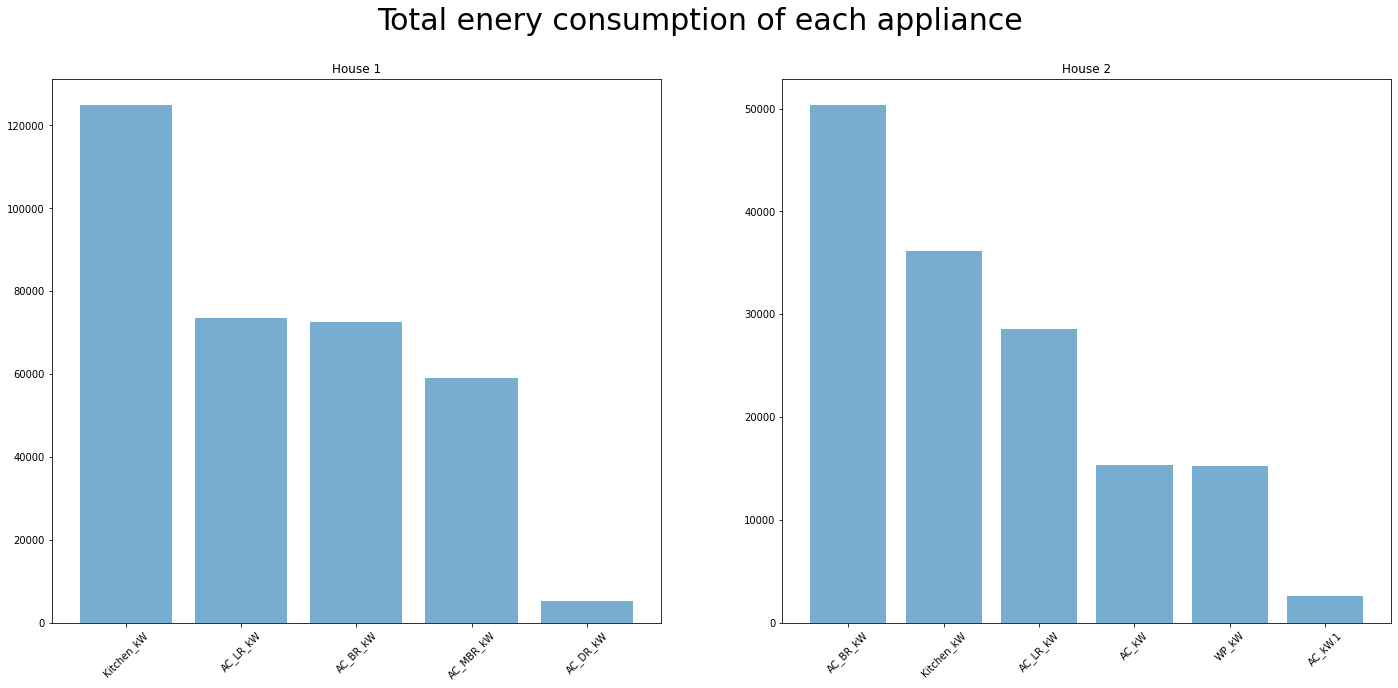

In [10]:
# Plot total energy sonsumption of each appliance from two houses
fig, axes = plt.subplots(1, 2, figsize=(24, 10))
plt.suptitle('Total enery consumption of each appliance', fontsize=30)
cons1 = df[1][df[1].drop(df[1].columns[0:27], axis=1).columns].sum().sort_values(ascending=False)
app1 = cons1.index
y_pos1 = np.arange(len(app1))
axes[0].bar(y_pos1, cons1.values, alpha=0.6)
plt.sca(axes[0])
plt.xticks(y_pos1, app1, rotation=45)
plt.title('House 1')

cons2 = df[2][df[2].drop(df[2].columns[0:27], axis=1).columns.values].sum().sort_values(ascending=False)
app2 = cons2.index
y_pos2 = np.arange(len(app2))
axes[1].bar(y_pos2, cons2.values, alpha=0.6)
plt.sca(axes[1])
plt.xticks(y_pos2, app2, rotation=45)
plt.title('House 2')


In [11]:
# Separating house 1 data into train, validation and test data

# df1_train = df[1].loc[:dates[1][250]]
# df1_val = df[1].loc[dates[1][251]:dates[1][325]]
# df1_test = df[1].loc[dates[1][326]:]

# df1_train = df[1].loc[:dates[1][15]]
# df1_val = df[1].loc[dates[1][15]:dates[1][17]]
# df1_test = df[1].loc[dates[1][17]:]

df1_train = df[1].loc[:dates[1][df1_train_max]]
df1_val = df[1].loc[dates[1][df1_train_max + 1]:dates[1][df1_val_max]]
df1_test = df[1].loc[dates[1][df1_test_min]:]

print('df_total.shape: ', df[1].shape)
print('df_train.shape: ', df1_train.shape)
print('df_val.shape: ', df1_val.shape)
print('df_test.shape: ', df1_test.shape)

df_total.shape:  (406748, 32)
df_train.shape:  (289440, 32)
df_val.shape:  (27360, 32)
df_test.shape:  (89948, 32)


In [12]:

def build_lstm_model(layers):
    model = Sequential()
    i = 0
    for i in range(len(layers) - 2):
        model.add(LSTM(
            input_dim=layers[i],
            units=layers[i + 1],
            # batch_input_shape=(60,3, 1),
            stateful=False,
            return_sequences=True if i < len(layers) - 3 else False))
        model.add(Dropout(0.3))

    model.add(Dense(layers[-1]))
    model.summary()
    return model


model = build_lstm_model([len(train_inputs), 64, 128, 256, 1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 64)          22528     
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         98816     
                                                                 
 dropout_1 (Dropout)         (None, None, 128)         0         
                                                                 
 lstm_2 (LSTM)               (None, 256)               394240    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 2

In [13]:
def process_data(df, dates, x_features, y_features, look_back=3):
    i = 0
    for date in dates:
        data = df.loc[date]
        len_data = data.shape[0]
        x = np.array([data[x_features].values[i:i + look_back]
                      for i in range(len_data - look_back)]).reshape(-1, look_back, len(train_inputs))
        y = data[y_features].values[look_back:, :]
        if i == 0:
            X = x
            Y = y
        else:
            X = np.append(X, x, axis=0)
            Y = np.append(Y, y, axis=0)
        i += 1
    return X, Y

In [14]:
# df1_train_max = 180
# df1_val_max = 220
# df1_test_min = 221

start = time.time()
# X_train, y_train = process_data(df[1], dates[1][:17], df[1].columns[0:27], ['Kitchen_kW'])
X_train, y_train = process_data(df[1], dates[1][:df1_test_min], train_inputs, output)
X_test, y_test = process_data(df[1], dates[1][df1_test_min:], train_inputs, output)
print('Process data time: ', time.time() - start)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Process data time:  227.05478191375732
(316140, 3, 23) (316140, 1) (89759, 3, 23) (89759, 1)


In [15]:
print(df[1].columns.values[27:])
print(dates[1][0:30])
print(dates[1][0:1])



['AC_DR_kW' 'Kitchen_kW' 'AC_BR_kW' 'AC_LR_kW' 'AC_MBR_kW']
['2018-06-01', '2018-06-02', '2018-06-03', '2018-06-04', '2018-06-05', '2018-06-06', '2018-06-07', '2018-06-08', '2018-06-09', '2018-06-10', '2018-06-11', '2018-06-12', '2018-06-13', '2018-06-14', '2018-06-15', '2018-06-16', '2018-06-17', '2018-06-18', '2018-06-19', '2018-06-20', '2018-06-21', '2018-06-22', '2018-06-23', '2018-06-24', '2018-06-25', '2018-06-26', '2018-06-27', '2018-06-28', '2018-06-29', '2018-06-30']
['2018-06-01']


In [16]:
start = time.time()
adam = Adam(lr=5e-5)
model.compile(loss='mean_squared_error', optimizer=adam)
checkpointer = ModelCheckpoint(filepath="./lstm_model_md_final.hdf5", verbose=1, save_best_only=True)
hist_lstm = model.fit(
    X_train,
    y_train,
    # batch_size=512,
    batch_size=60,
    verbose=1,
    epochs=10,
    validation_split=0.4,
    callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)

Epoch 1/10
3160/3162 [============================>.] - ETA: 0s - loss: 0.0275
Epoch 00001: val_loss improved from inf to 0.02958, saving model to .\lstm_model_final.hdf5
3162/3162 [==============================] - 91s 27ms/step - loss: 0.0275 - val_loss: 0.0296
Epoch 2/10
3162/3162 [==============================] - ETA: 0s - loss: 0.0238
Epoch 00002: val_loss did not improve from 0.02958
3162/3162 [==============================] - 80s 25ms/step - loss: 0.0238 - val_loss: 0.0296
Epoch 3/10
3161/3162 [============================>.] - ETA: 0s - loss: 0.0235
Epoch 00003: val_loss did not improve from 0.02958
3162/3162 [==============================] - 82s 26ms/step - loss: 0.0235 - val_loss: 0.0317
Epoch 4/10
3160/3162 [============================>.] - ETA: 0s - loss: 0.0233
Epoch 00004: val_loss did not improve from 0.02958
3162/3162 [==============================] - 82s 26ms/step - loss: 0.0233 - val_loss: 0.0316
Epoch 5/10
3162/3162 [==============================] - ETA: 0s - l

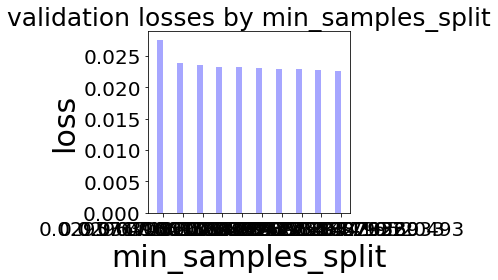

In [17]:
def plot_losses(losses, min_samples_split):
    index = np.arange(len(min_samples_split))
    bar_width = 0.3
    opacity = 0.35

    plt.bar(index, losses, bar_width, alpha=opacity, color='b')
    plt.xlabel('min_samples_split', fontsize=30)
    plt.ylabel('loss', fontsize=30)
    plt.title('validation losses by min_samples_split', fontsize='25')
    plt.xticks(index + bar_width / 2, min_samples_split, fontsize=20)
    plt.yticks(fontsize=20)
    plt.rcParams["figure.figsize"] = [24, 15]
    plt.tight_layout()


train_loss = hist_lstm.history['loss']
val_loss = hist_lstm.history['val_loss']

plot_losses(train_loss, val_loss)

In [18]:
model = load_model('lstm_model_md_final.hdf5')
pred_lstm = model.predict(X_test).reshape(-1)
print(pred_lstm.shape)


(89759,)


In [19]:
def mse_loss(y_predict, y):
    return np.mean(np.square(y_predict - y))


def mae_loss(y_predict, y):
    return np.mean(np.abs(y_predict - y))


y_test = y_test.reshape(-1)

mse_loss_lstm = mse_loss(pred_lstm, y_test)
mae_loss_lstm = mae_loss(pred_lstm, y_test)
print('Mean square error on test set: ', mse_loss_lstm)
print('Mean absolute error on the test set: ', mae_loss_lstm)

Mean square error on test set:  0.03419193668762094
Mean absolute error on the test set:  0.15283186813809888


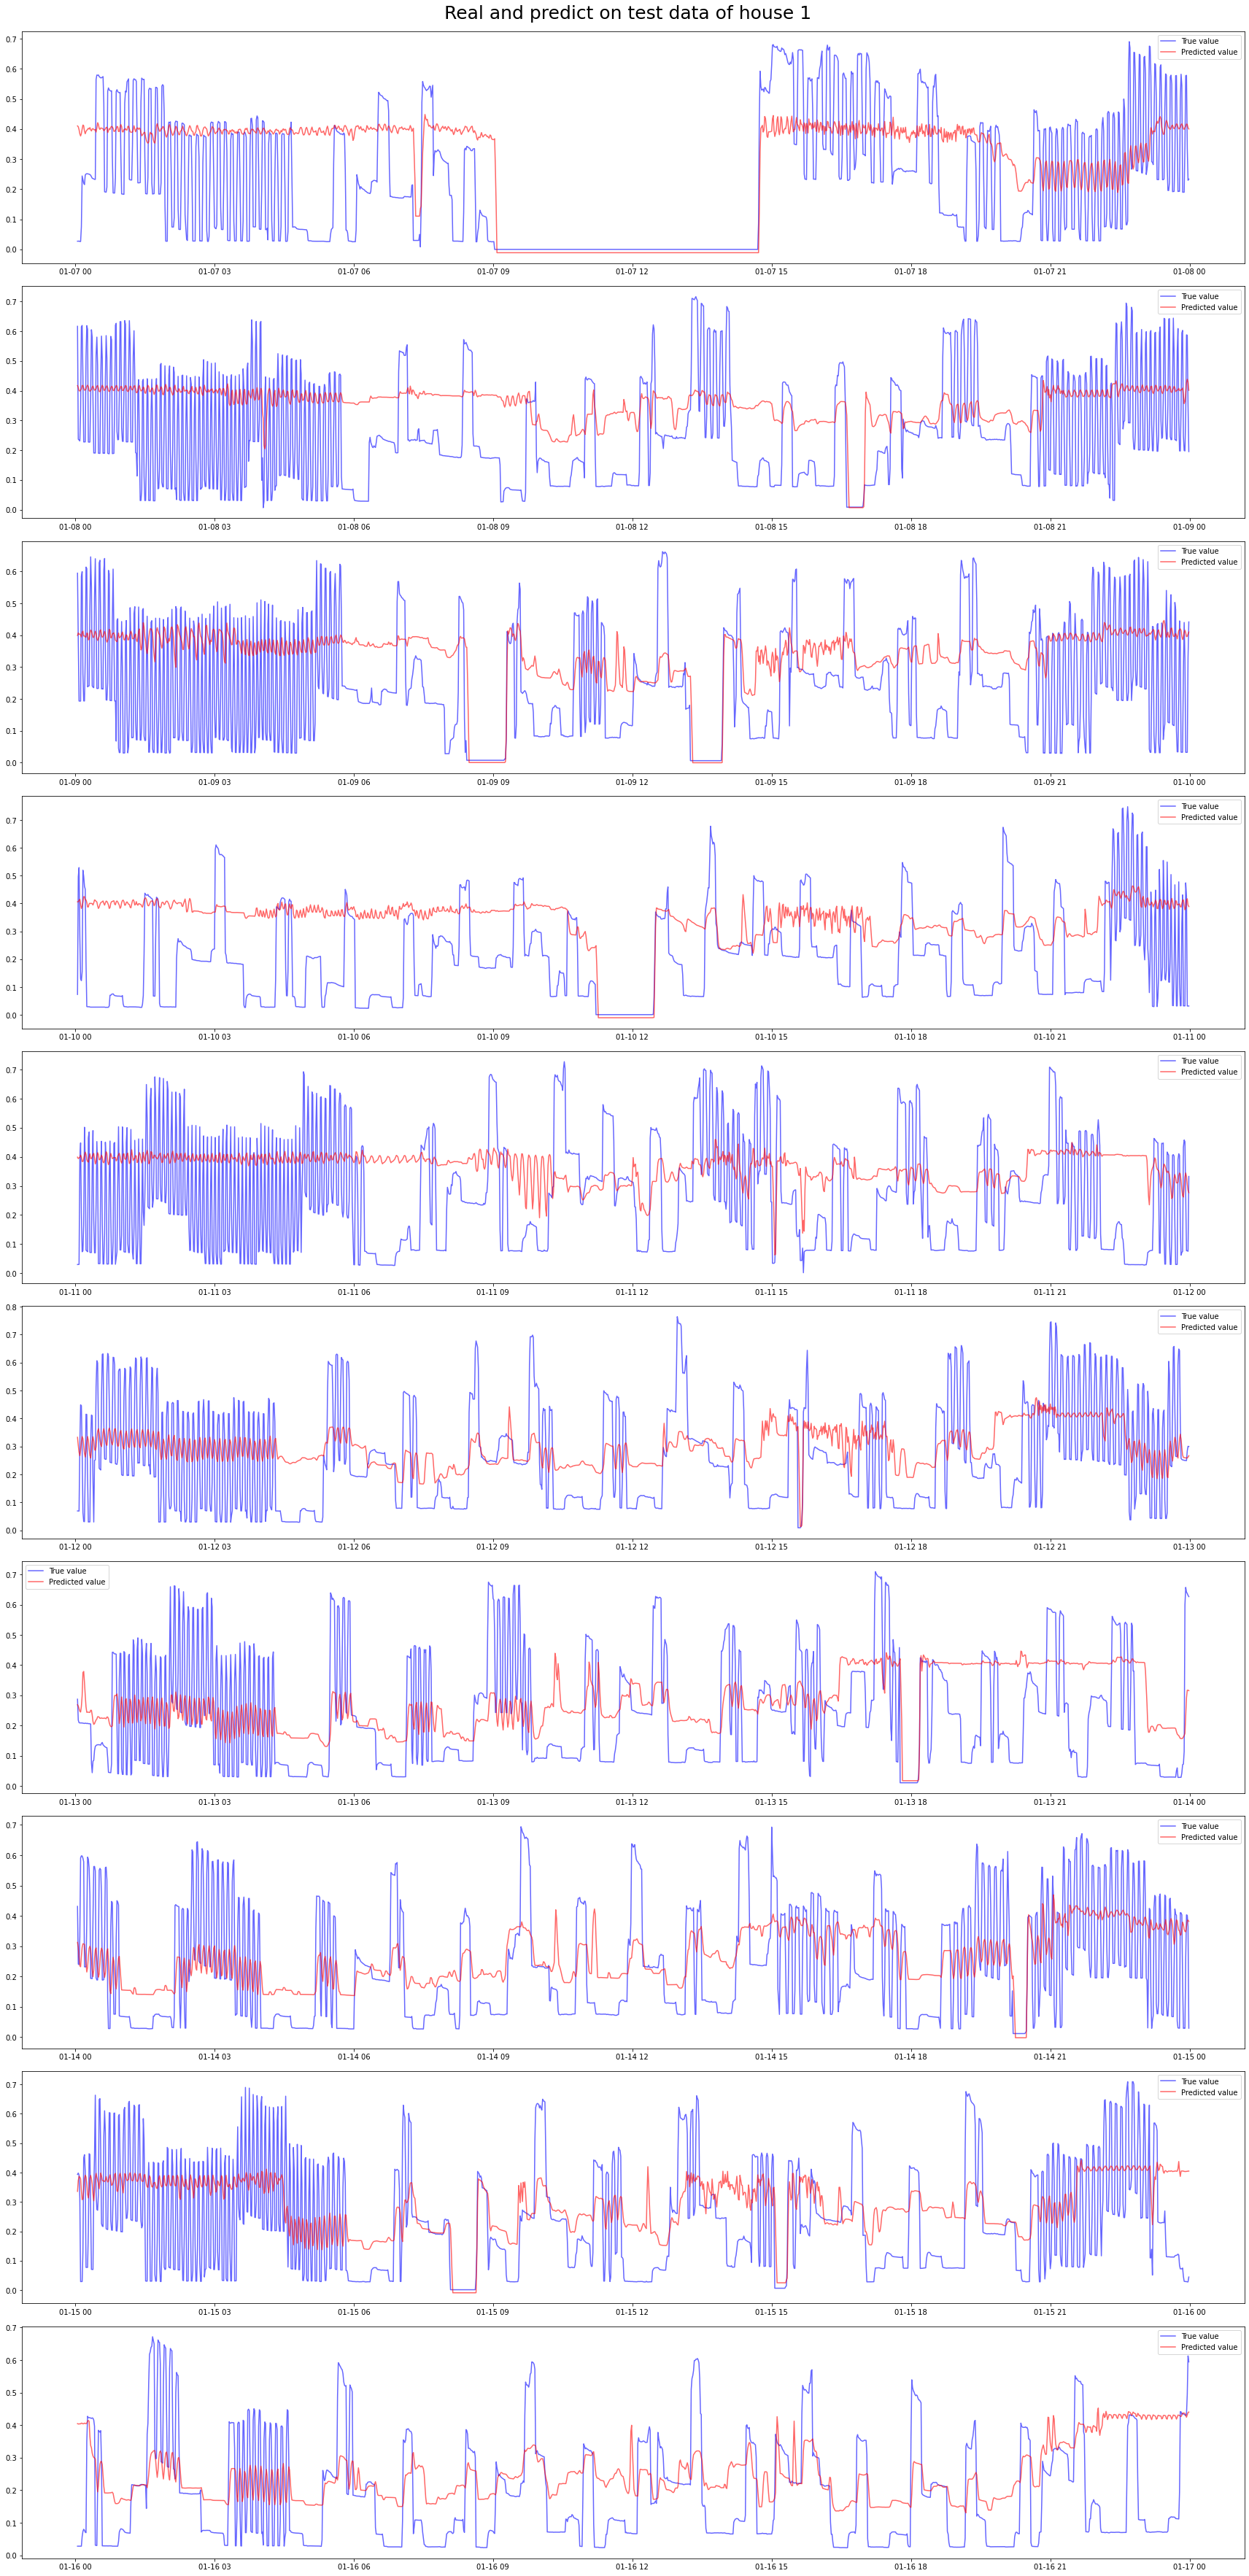

In [25]:
def plot_each_app(df, dates, predict, y_test, title, look_back=0):
    num_date = len(dates)
    fig, axes = plt.subplots(num_date, 1, figsize=(24, num_date * 5))
    plt.suptitle(title, fontsize='25')
    fig.tight_layout()
    fig.subplots_adjust(top=0.97)
    for i in range(num_date):
        if i == 0: l = 0
        ind = df.loc[dates[i]].index[look_back:]
        display()
        axes.flat[i].plot(ind, y_test[l:l + len(ind)], color='blue', alpha=0.6, label='True value')
        axes.flat[i].plot(ind, predict[l:l + len(ind)], color='red', alpha=0.6, label='Predicted value')
        axes.flat[i].legend()
        l = l + len(ind)


plot_each_app(df1_test, dates[1][df1_test_min:df1_test_min + 10], pred_lstm, y_test,
              'Real and predict on test data of house 1', look_back=3)

### Test LST model on house 2

In [53]:
df[2] = read_house_data(9)
df2_mains2 = df[2].iloc[:, 1:].sum(axis=1)
df[2] = df[2][:max_rows]
print('House data has shape: '.format(2), df[2].shape)
display(df[2].head(3))

# Setup Metadata
for i, column in enumerate(md):
    df[2].insert(i + 1, column, meta_data[2][column])
display(df[2])

# Setup Dates
dates[2] = [str(time)[:10] for time in df[2].index.values]
dates[2] = sorted(list(set(dates[2])))
print('House {0} data contain {1} days from {2} to {3}.'.format(2, len(dates[2]), dates[2][0], dates[2][-1]))
print(dates[2], '\n')

House data has shape:  (406748, 7)


,Usage_kW,AC_LR_kW,AC_BR_kW,AC_kW,AC_kW.1,Kitchen_kW,WP_kW
2018-06-01 00:00:00,1.4460,0.0005,1.0470,0.0009,0.0001,0.1598,0.0634
2018-06-01 00:01:00,1.4557,0.0005,1.0523,0.0008,0.0001,0.1597,0.0636
2018-06-01 00:02:00,1.4553,0.0005,1.0545,0.0009,0.0001,0.1602,0.0637


,Usage_kW,Property_Area_sqft,No_of_Floors,Building_Year,Ceiling_Height_ft,Total_No_of_Rooms,Bedrooms,Livingrooms,Drawingrooms,Kitchen,...,No_of_Electric_Heaters,No_of_Irons,No_of_Lighting_Devices,No_of_UPS,AC_LR_kW,AC_BR_kW,AC_kW,AC_kW.1,Kitchen_kW,WP_kW
2018-06-01 00:00:00,1.4460,2722.51,2.0,2013.0,15.0,7.0,4.0,1.0,1.0,1.0,...,0.0,1.0,30.0,1.0,0.0005,1.0470,0.0009,0.0001,0.1598,0.0634
2018-06-01 00:01:00,1.4557,2722.51,2.0,2013.0,15.0,7.0,4.0,1.0,1.0,1.0,...,0.0,1.0,30.0,1.0,0.0005,1.0523,0.0008,0.0001,0.1597,0.0636
2018-06-01 00:02:00,1.4553,2722.51,2.0,2013.0,15.0,7.0,4.0,1.0,1.0,1.0,...,0.0,1.0,30.0,1.0,0.0005,1.0545,0.0009,0.0001,0.1602,0.0637
2018-06-01 00:03:00,1.4651,2722.51,2.0,2013.0,15.0,7.0,4.0,1.0,1.0,1.0,...,0.0,1.0,30.0,1.0,0.0005,1.0520,0.0009,0.0001,0.1598,0.0522
2018-06-01 00:04:00,1.4735,2722.51,2.0,2013.0,15.0,7.0,4.0,1.0,1.0,1.0,...,0.0,1.0,30.0,1.0,0.0005,1.0500,0.0009,0.0002,0.1600,0.0217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-10 11:03:00,0.0186,2722.51,2.0,2013.0,15.0,7.0,4.0,1.0,1.0,1.0,...,0.0,1.0,30.0,1.0,0.0016,0.0027,0.0000,0.0015,0.0001,0.0050
2019-03-10 11:04:00,0.0186,2722.51,2.0,2013.0,15.0,7.0,4.0,1.0,1.0,1.0,...,0.0,1.0,30.0,1.0,0.0016,0.0027,0.0000,0.0015,0.0002,0.0050
2019-03-10 11:05:00,0.0185,2722.51,2.0,2013.0,15.0,7.0,4.0,1.0,1.0,1.0,...,0.0,1.0,30.0,1.0,0.0016,0.0027,0.0000,0.0014,0.0002,0.0050
2019-03-10 11:06:00,0.0186,2722.51,2.0,2013.0,15.0,7.0,4.0,1.0,1.0,1.0,...,0.0,1.0,30.0,1.0,0.0016,0.0027,0.0000,0.0015,0.0002,0.0050


House 2 data contain 283 days from 2018-06-01 to 2019-03-10.
['2018-06-01', '2018-06-02', '2018-06-03', '2018-06-04', '2018-06-05', '2018-06-06', '2018-06-07', '2018-06-08', '2018-06-09', '2018-06-10', '2018-06-11', '2018-06-12', '2018-06-13', '2018-06-14', '2018-06-15', '2018-06-16', '2018-06-17', '2018-06-18', '2018-06-19', '2018-06-20', '2018-06-21', '2018-06-22', '2018-06-23', '2018-06-24', '2018-06-25', '2018-06-26', '2018-06-27', '2018-06-28', '2018-06-29', '2018-06-30', '2018-07-01', '2018-07-02', '2018-07-03', '2018-07-04', '2018-07-05', '2018-07-06', '2018-07-07', '2018-07-08', '2018-07-09', '2018-07-10', '2018-07-11', '2018-07-12', '2018-07-13', '2018-07-14', '2018-07-15', '2018-07-16', '2018-07-17', '2018-07-18', '2018-07-19', '2018-07-20', '2018-07-21', '2018-07-22', '2018-07-23', '2018-07-24', '2018-07-25', '2018-07-26', '2018-07-27', '2018-07-28', '2018-07-29', '2018-07-30', '2018-07-31', '2018-08-01', '2018-08-02', '2018-08-03', '2018-08-04', '2018-08-05', '2018-08-06', 

In [54]:
start = time.time()
X_2, y_2 = process_data(df[2], dates[2], train_inputs, output)
y_2 = y_2.reshape(-1)
print('Process data time: ', time.time() - start)
print(y_2.shape)

Process data time:  242.2277867794037
(405899,)


In [55]:

pred_lstm_h2 = model.predict(X_2).reshape(-1)
mse_loss_lstm_h2 = mse_loss(pred_lstm_h2, y_2)
mae_loss_lstm_h2 = mae_loss(pred_lstm_h2, y_2)
print('Mean square error on test set: ', mse_loss_lstm_h2)
print('Mean absolute error on the test set: ', mae_loss_lstm_h2)

Mean square error on test set:  0.0548482354797994
Mean absolute error on the test set:  0.21117563052386454


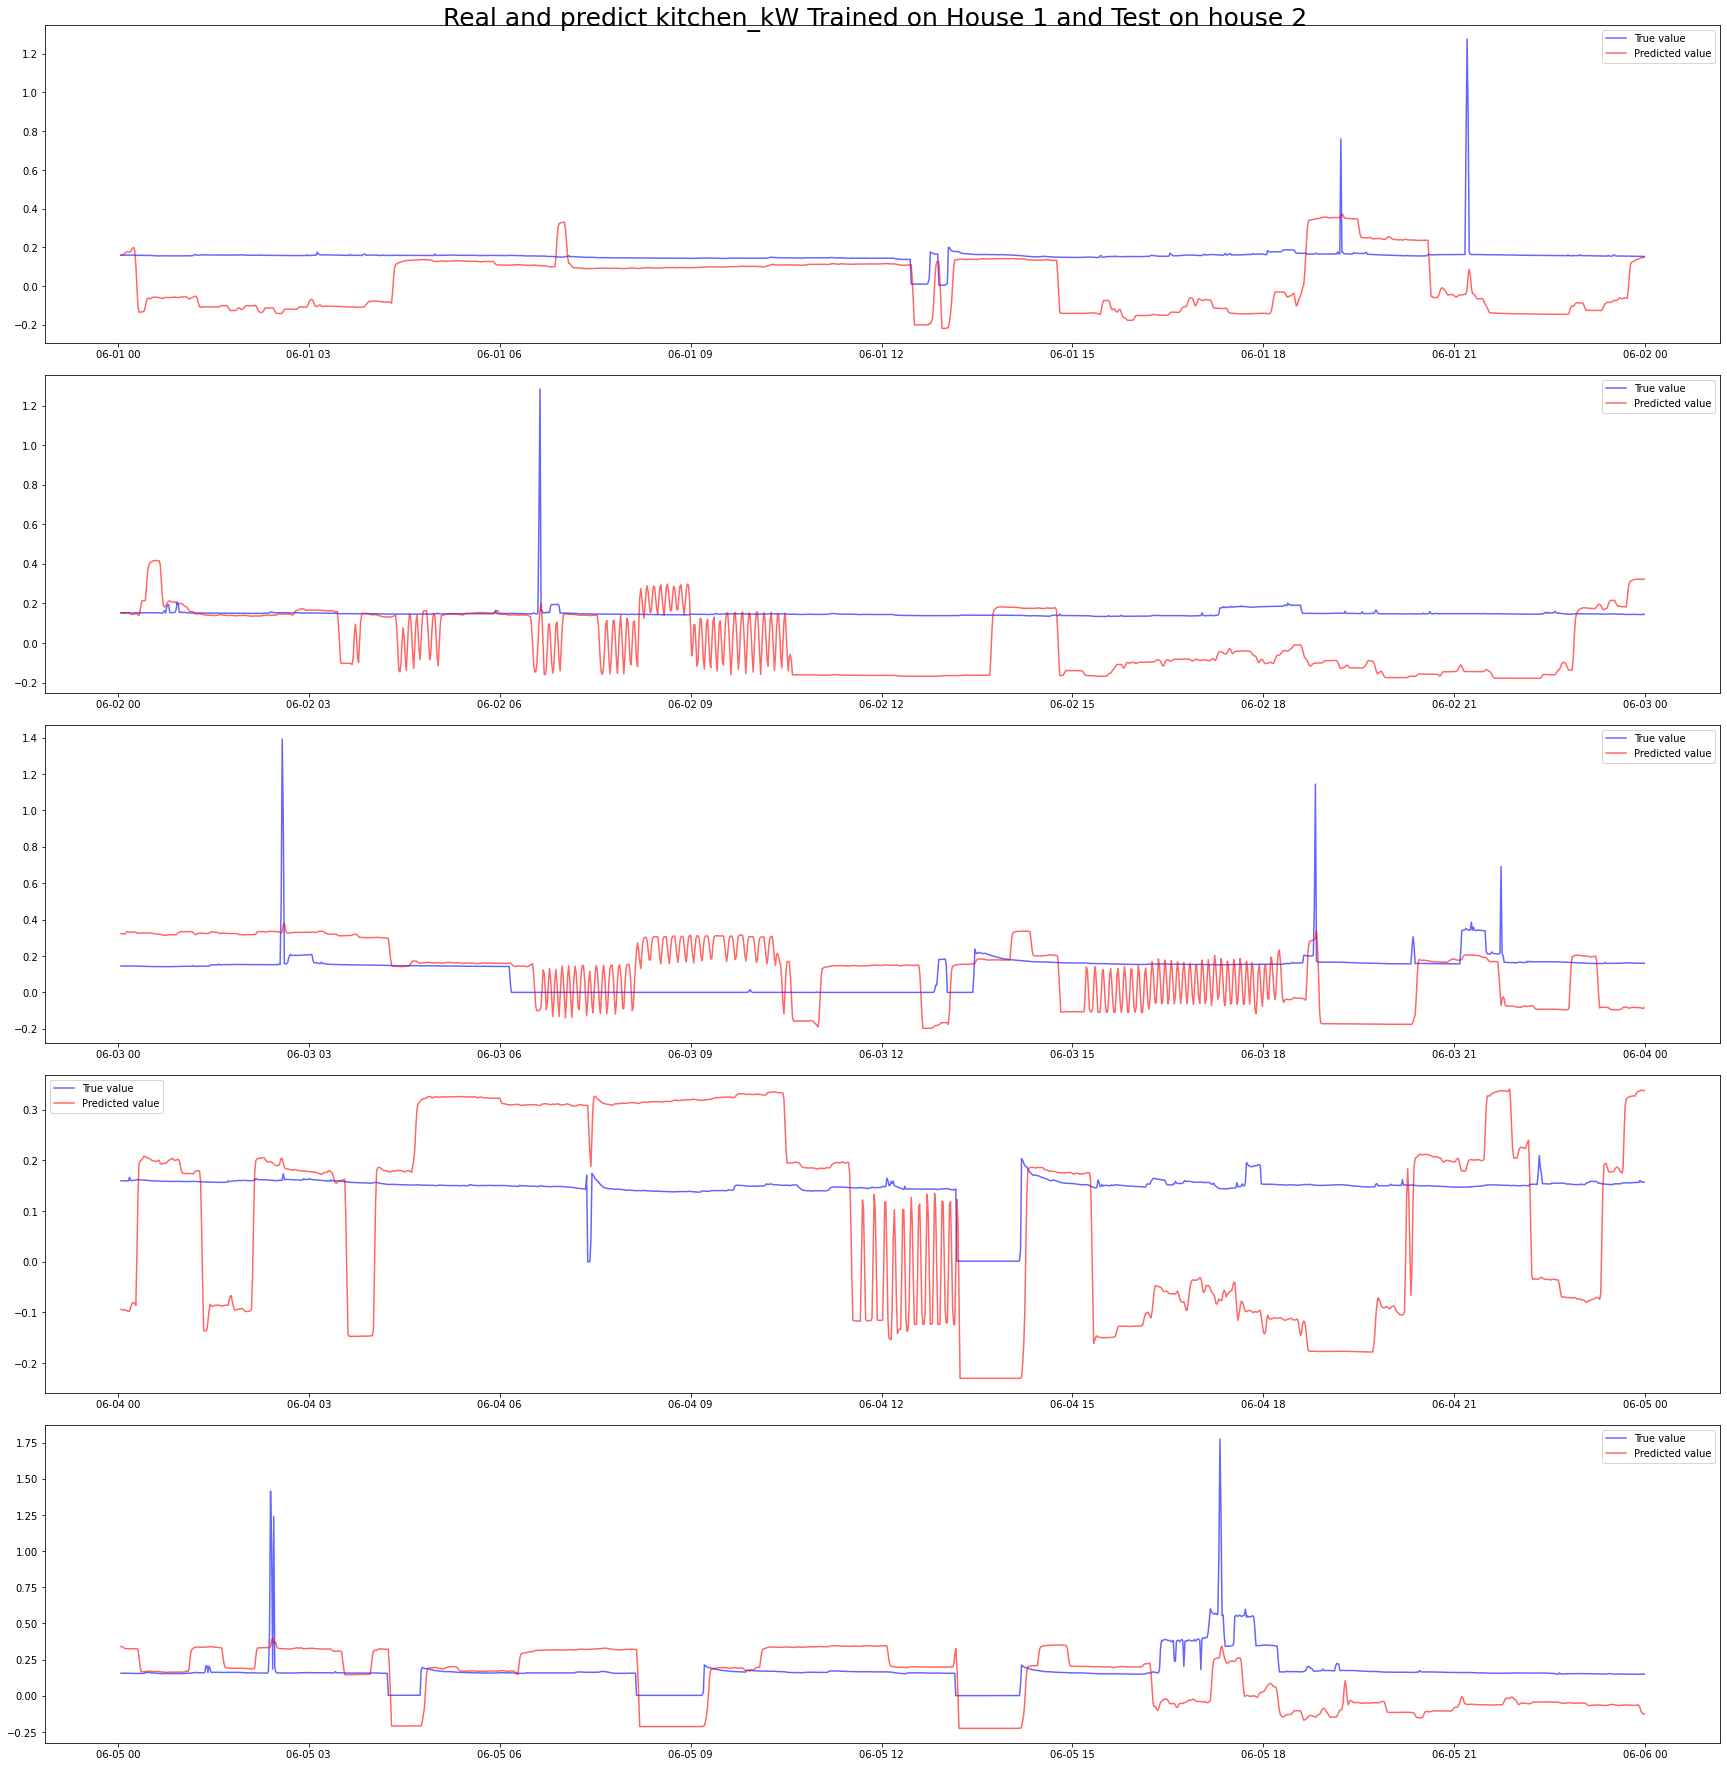

In [56]:
# plot_each_app(df[2], dates[2], pred_lstm_h2, y_2,
#               'Real and predict kitchen_kW Trained on House 1 and Test on house 2', look_back=50)

plot_each_app(df[2], dates[2][:5], pred_lstm_h2, y_2,
              'Real and predict kitchen_kW Trained on House 1 and Test on house 2', look_back=3)

### Test LST model on house 3

In [72]:
house = 10
meta_data[2] = md.iloc[house - 1]

df[2] = read_house_data(house)
df2_mains2 = df[2].iloc[:, 1:].sum(axis=1)
df[2] = df[2][:max_rows]
print('House data has shape: '.format(2), df[2].shape)
display(df[2].head(3))

# Setup Metadata
for i, column in enumerate(md):
    df[2].insert(i + 1, column, meta_data[2][column])
display(df[2])

# Setup Dates
dates[2] = [str(time)[:10] for time in df[2].index.values]
dates[2] = sorted(list(set(dates[2])))
print('House {0} data contain {1} days from {2} to {3}.'.format(2, len(dates[2]), dates[2][0], dates[2][-1]))
print(dates[2][:10], '\n')


House data has shape:  (406748, 5)


,Usage_kW,AC_kW,AC_kW.1,Kitchen_kW,UPS_kW
2018-06-01 00:00:00,0.7415,0.0004,0.0016,0.3154,0.4073
2018-06-01 00:01:00,0.7820,0.0004,0.0016,0.3172,0.4460
2018-06-01 00:02:00,0.7810,0.0004,0.0016,0.3185,0.4438


,Usage_kW,Property_Area_sqft,No_of_Floors,Building_Year,Ceiling_Height_ft,Total_No_of_Rooms,Bedrooms,Livingrooms,Drawingrooms,Kitchen,...,No_of_Water_Dispensers,No_of _Water_Pumps,No_of_Electric_Heaters,No_of_Irons,No_of_Lighting_Devices,No_of_UPS,AC_kW,AC_kW.1,Kitchen_kW,UPS_kW
2018-06-01 00:00:00,0.7415,8167.52,2.0,1995.0,10.0,7.0,4.0,1.0,1.0,1.0,...,0.0,0.0,3.0,1.0,21.0,1.0,0.0004,0.0016,0.3154,0.4073
2018-06-01 00:01:00,0.7820,8167.52,2.0,1995.0,10.0,7.0,4.0,1.0,1.0,1.0,...,0.0,0.0,3.0,1.0,21.0,1.0,0.0004,0.0016,0.3172,0.4460
2018-06-01 00:02:00,0.7810,8167.52,2.0,1995.0,10.0,7.0,4.0,1.0,1.0,1.0,...,0.0,0.0,3.0,1.0,21.0,1.0,0.0004,0.0016,0.3185,0.4438
2018-06-01 00:03:00,0.7175,8167.52,2.0,1995.0,10.0,7.0,4.0,1.0,1.0,1.0,...,0.0,0.0,3.0,1.0,21.0,1.0,0.0005,0.0016,0.3191,0.3794
2018-06-01 00:04:00,0.6996,8167.52,2.0,1995.0,10.0,7.0,4.0,1.0,1.0,1.0,...,0.0,0.0,3.0,1.0,21.0,1.0,0.0005,0.0016,0.3191,0.3615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-10 11:03:00,0.2820,8167.52,2.0,1995.0,10.0,7.0,4.0,1.0,1.0,1.0,...,0.0,0.0,3.0,1.0,21.0,1.0,0.0001,0.0004,0.1958,0.0664
2019-03-10 11:04:00,0.0997,8167.52,2.0,1995.0,10.0,7.0,4.0,1.0,1.0,1.0,...,0.0,0.0,3.0,1.0,21.0,1.0,0.0001,0.0004,0.0448,0.0350
2019-03-10 11:05:00,0.0918,8167.52,2.0,1995.0,10.0,7.0,4.0,1.0,1.0,1.0,...,0.0,0.0,3.0,1.0,21.0,1.0,0.0001,0.0004,0.0369,0.0351
2019-03-10 11:06:00,0.1042,8167.52,2.0,1995.0,10.0,7.0,4.0,1.0,1.0,1.0,...,0.0,0.0,3.0,1.0,21.0,1.0,0.0001,0.0004,0.0372,0.0472


House 2 data contain 283 days from 2018-06-01 to 2019-03-10.
['2018-06-01', '2018-06-02', '2018-06-03', '2018-06-04', '2018-06-05', '2018-06-06', '2018-06-07', '2018-06-08', '2018-06-09', '2018-06-10'] 



Process data time:  247.08253502845764
(405899,)
Mean square error on test set:  0.04138673866100127
Mean absolute error on the test set:  0.1794596062424394


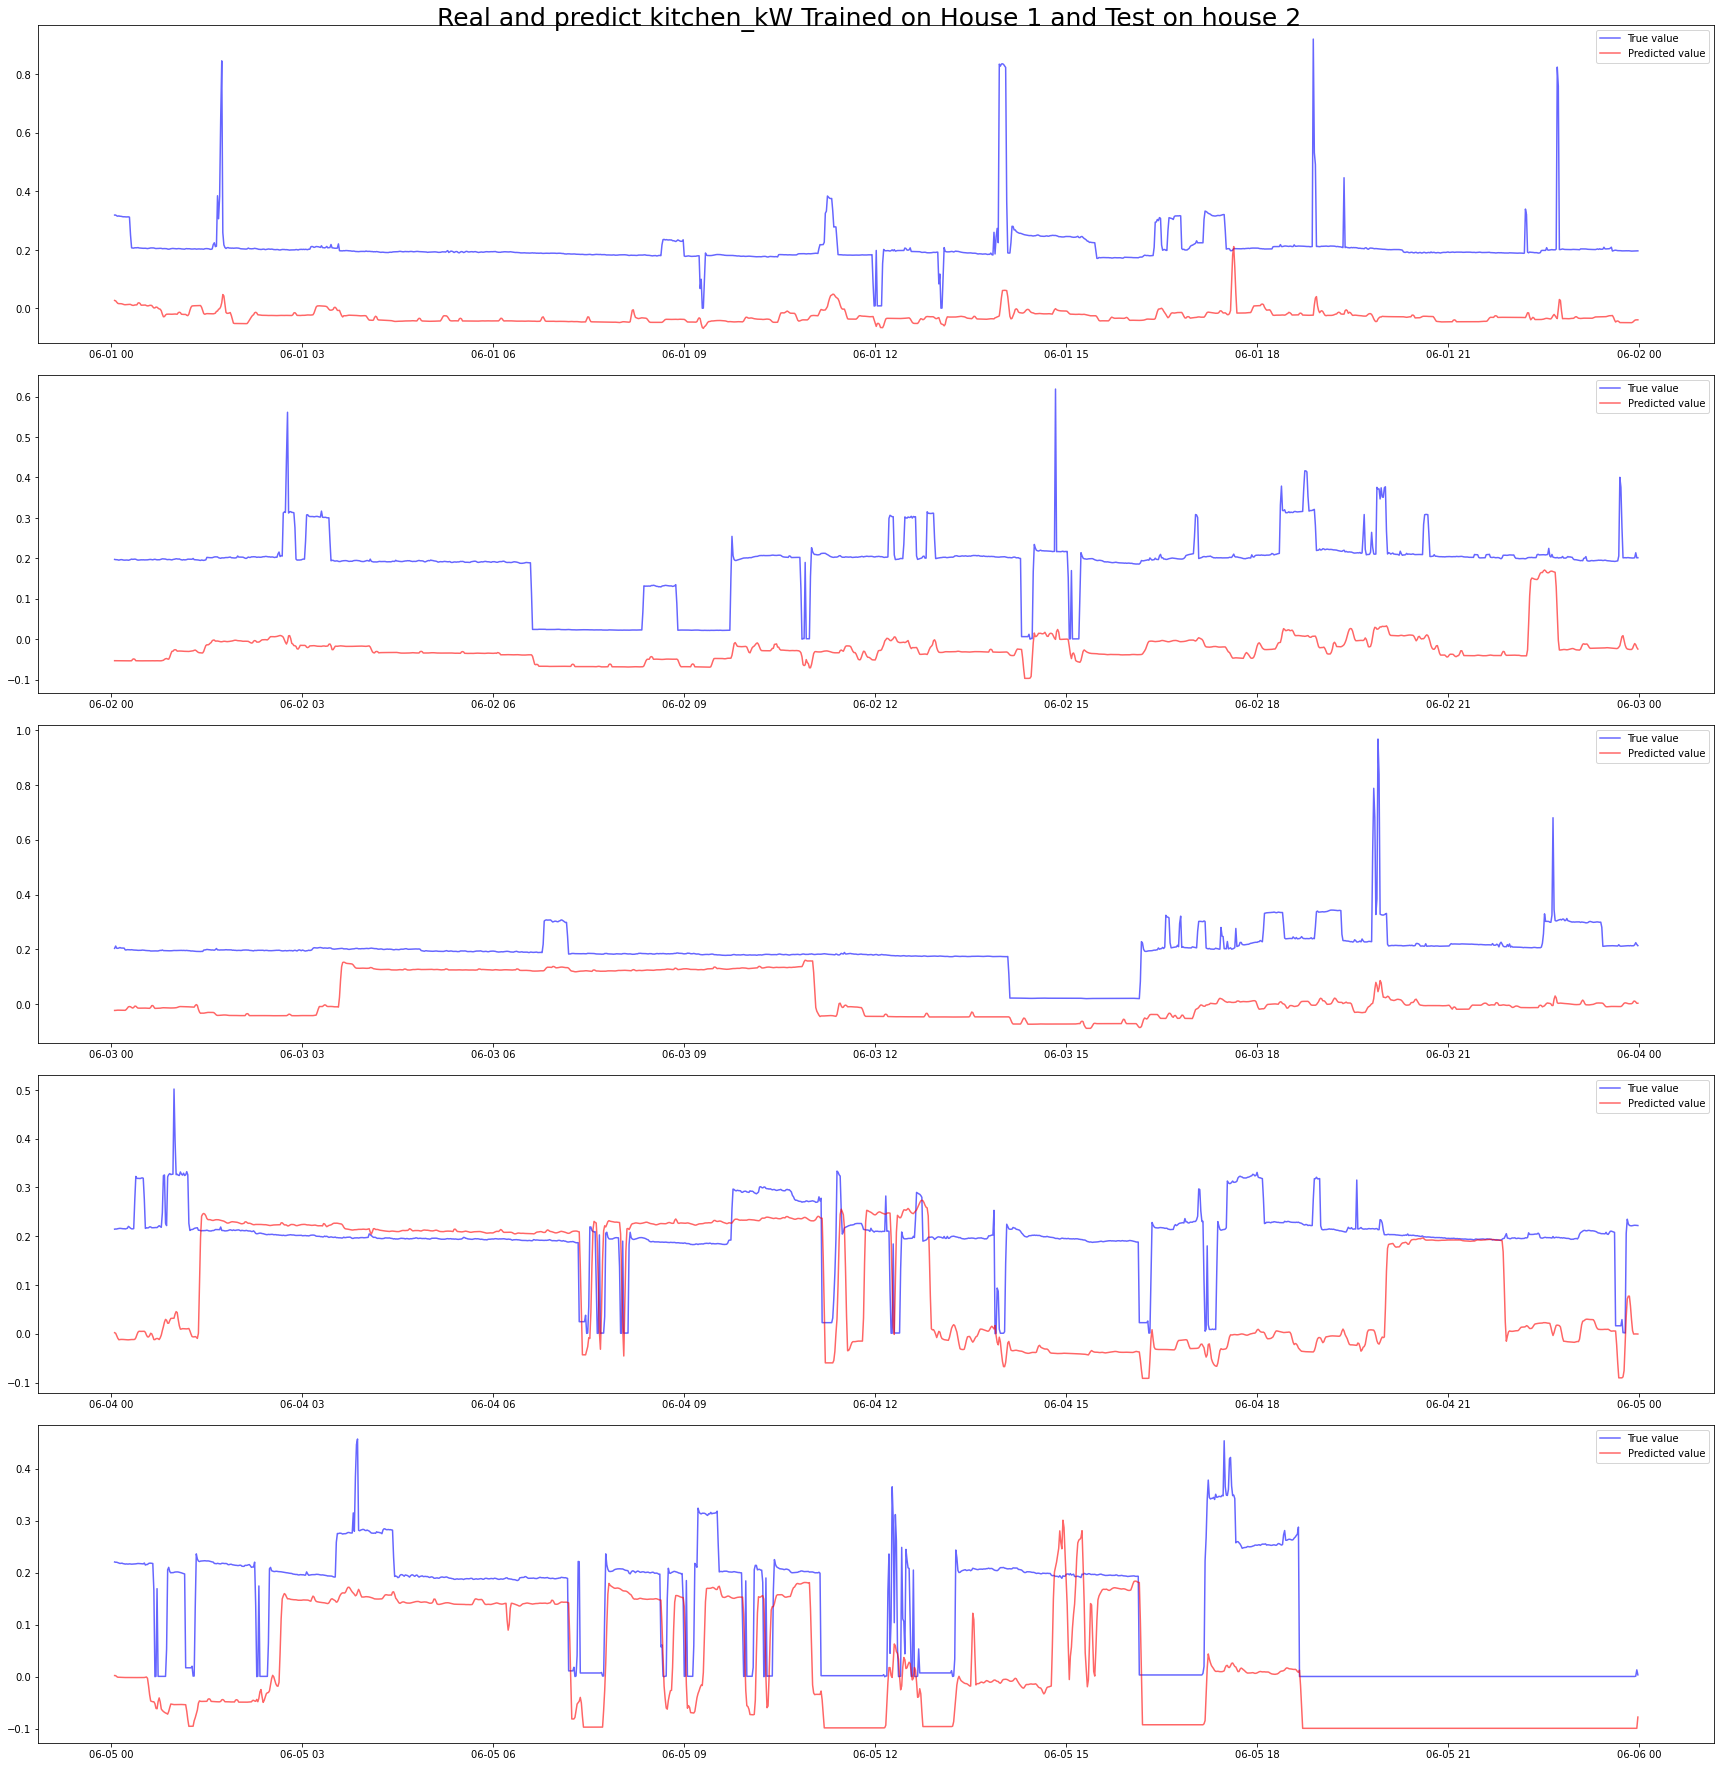

In [73]:
# Process Data
start = time.time()
X_2, y_2 = process_data(df[2], dates[2], train_inputs, output)
y_2 = y_2.reshape(-1)
print('Process data time: ', time.time() - start)
print(y_2.shape)

# Prediction
pred_lstm_h2 = model.predict(X_2).reshape(-1)
mse_loss_lstm_h2 = mse_loss(pred_lstm_h2, y_2)
mae_loss_lstm_h2 = mae_loss(pred_lstm_h2, y_2)
print('Mean square error on test set: ', mse_loss_lstm_h2)
print('Mean absolute error on the test set: ', mae_loss_lstm_h2)

# Print Results
plot_each_app(df[2], dates[2][:5], pred_lstm_h2, y_2,
              'Real and predict kitchen_kW Trained on House 1 and Test on house 2', look_back=3)

### Test LST model on house 4

In [74]:
house = 15
meta_data[2] = md.iloc[house - 1]

df[2] = read_house_data(house)
df2_mains2 = df[2].iloc[:, 1:].sum(axis=1)
df[2] = df[2][:max_rows]
print('House data has shape: '.format(2), df[2].shape)
display(df[2].head(3))

# Setup Metadata
for i, column in enumerate(md):
    df[2].insert(i + 1, column, meta_data[2][column])
display(df[2])

# Setup Dates
dates[2] = [str(time)[:10] for time in df[2].index.values]
dates[2] = sorted(list(set(dates[2])))
print('House {0} data contain {1} days from {2} to {3}.'.format(2, len(dates[2]), dates[2][0], dates[2][-1]))
print(dates[2][:10], '\n')


House data has shape:  (406748, 5)


,Usage_kW,AC_BR_kW,Kitchen_kW,LR_kW,AC_BR_kW.1
2018-06-01 00:00:00,6.3809,2.0147,0.4519,0.1882,0.0014
2018-06-01 00:01:00,5.7532,2.0108,0.4516,0.1880,0.0011
2018-06-01 00:02:00,4.1774,0.4611,0.4516,0.1953,0.0011


,Usage_kW,Property_Area_sqft,No_of_Floors,Building_Year,Ceiling_Height_ft,Total_No_of_Rooms,Bedrooms,Livingrooms,Drawingrooms,Kitchen,...,No_of_Water_Dispensers,No_of _Water_Pumps,No_of_Electric_Heaters,No_of_Irons,No_of_Lighting_Devices,No_of_UPS,AC_BR_kW,Kitchen_kW,LR_kW,AC_BR_kW.1
2018-06-01 00:00:00,6.3809,5445.01,2.0,2012.0,10.0,12.0,6.0,3.0,1.0,2.0,...,1.0,1.0,0.0,1.0,146.0,2.0,2.0147,0.4519,0.1882,0.0014
2018-06-01 00:01:00,5.7532,5445.01,2.0,2012.0,10.0,12.0,6.0,3.0,1.0,2.0,...,1.0,1.0,0.0,1.0,146.0,2.0,2.0108,0.4516,0.1880,0.0011
2018-06-01 00:02:00,4.1774,5445.01,2.0,2012.0,10.0,12.0,6.0,3.0,1.0,2.0,...,1.0,1.0,0.0,1.0,146.0,2.0,0.4611,0.4516,0.1953,0.0011
2018-06-01 00:03:00,5.1689,5445.01,2.0,2012.0,10.0,12.0,6.0,3.0,1.0,2.0,...,1.0,1.0,0.0,1.0,146.0,2.0,0.0353,0.4542,0.1996,0.0018
2018-06-01 00:04:00,5.7982,5445.01,2.0,2012.0,10.0,12.0,6.0,3.0,1.0,2.0,...,1.0,1.0,0.0,1.0,146.0,2.0,0.0348,0.4550,0.2007,0.0020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-10 11:03:00,0.8149,5445.01,2.0,2012.0,10.0,12.0,6.0,3.0,1.0,2.0,...,1.0,1.0,0.0,1.0,146.0,2.0,0.0029,0.3118,0.1111,0.0010
2019-03-10 11:04:00,0.8049,5445.01,2.0,2012.0,10.0,12.0,6.0,3.0,1.0,2.0,...,1.0,1.0,0.0,1.0,146.0,2.0,0.0030,0.3192,0.1111,0.0011
2019-03-10 11:05:00,0.7966,5445.01,2.0,2012.0,10.0,12.0,6.0,3.0,1.0,2.0,...,1.0,1.0,0.0,1.0,146.0,2.0,0.0029,0.3171,0.1111,0.0011
2019-03-10 11:06:00,0.7967,5445.01,2.0,2012.0,10.0,12.0,6.0,3.0,1.0,2.0,...,1.0,1.0,0.0,1.0,146.0,2.0,0.0028,0.3177,0.1112,0.0010


House 2 data contain 283 days from 2018-06-01 to 2019-03-10.
['2018-06-01', '2018-06-02', '2018-06-03', '2018-06-04', '2018-06-05', '2018-06-06', '2018-06-07', '2018-06-08', '2018-06-09', '2018-06-10'] 



Process data time:  244.39548683166504
(405899,)
Mean square error on test set:  0.0832695055463762
Mean absolute error on the test set:  0.23365358888571652


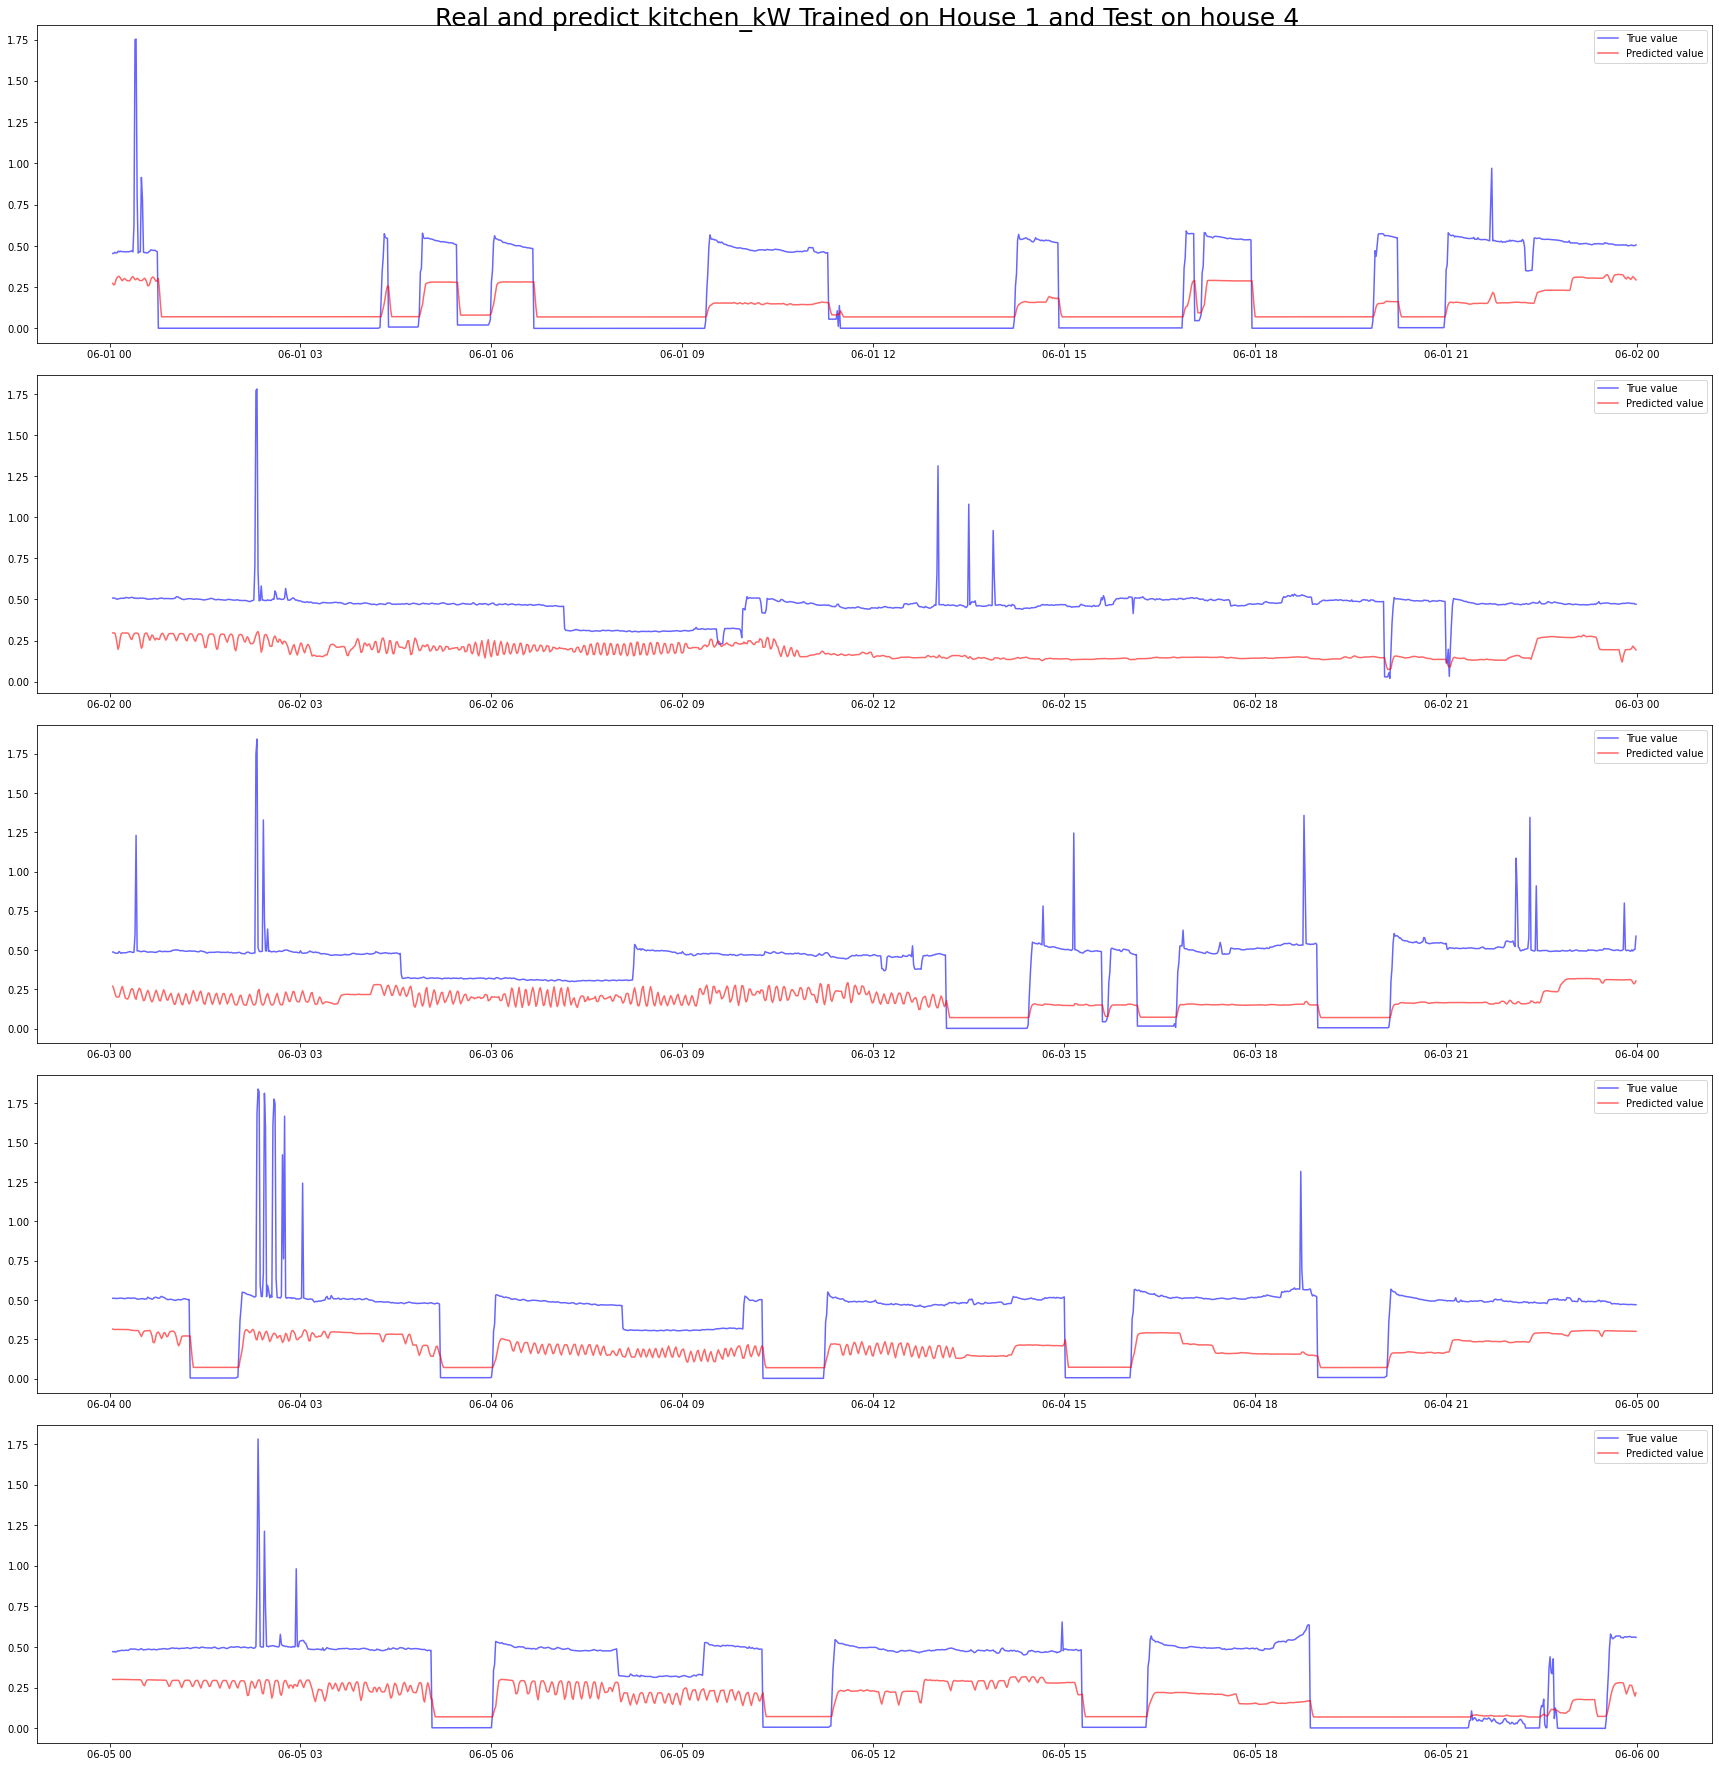

In [75]:
# Process Data
start = time.time()
X_2, y_2 = process_data(df[2], dates[2], train_inputs, output)
y_2 = y_2.reshape(-1)
print('Process data time: ', time.time() - start)
print(y_2.shape)

# Prediction
pred_lstm_h2 = model.predict(X_2).reshape(-1)
mse_loss_lstm_h2 = mse_loss(pred_lstm_h2, y_2)
mae_loss_lstm_h2 = mae_loss(pred_lstm_h2, y_2)
print('Mean square error on test set: ', mse_loss_lstm_h2)
print('Mean absolute error on the test set: ', mae_loss_lstm_h2)

# Print Results
plot_each_app(df[2], dates[2][:5], pred_lstm_h2, y_2,
              'Real and predict kitchen_kW Trained on House 1 and Test on house 4', look_back=3)

### Test LST model on house 5

In [81]:
house = 19
meta_data[2] = md.iloc[house - 1]

df[2] = read_house_data(house)
df2_mains2 = df[2].iloc[:, 1:].sum(axis=1)
df[2] = df[2][:max_rows]
print('House data has shape: '.format(2), df[2].shape)
display(df[2].head(3))

# Setup Metadata
for i, column in enumerate(md):
    df[2].insert(i + 1, column, meta_data[2][column])
display(df[2])

# Setup Dates
dates[2] = [str(time)[:10] for time in df[2].index.values]
dates[2] = sorted(list(set(dates[2])))
print('House {0} data contain {1} days from {2} to {3}.'.format(2, len(dates[2]), dates[2][0], dates[2][-1]))
print(dates[2][:10], '\n')


House data has shape:  (406748, 5)


,Usage_kW,AC_BR_kW,AC_DR_kW,Kitchen_kW,UPS_kW
2018-06-01 00:00:00,2.9196,0.0005,0.0004,0.3637,0.3458
2018-06-01 00:01:00,2.9253,0.0001,0.0004,0.3624,0.3498
2018-06-01 00:02:00,2.9209,0.0002,0.0002,0.3664,0.3512


,Usage_kW,Property_Area_sqft,No_of_Floors,Building_Year,Ceiling_Height_ft,Total_No_of_Rooms,Bedrooms,Livingrooms,Drawingrooms,Kitchen,...,No_of_Water_Dispensers,No_of _Water_Pumps,No_of_Electric_Heaters,No_of_Irons,No_of_Lighting_Devices,No_of_UPS,AC_BR_kW,AC_DR_kW,Kitchen_kW,UPS_kW
2018-06-01 00:00:00,2.9196,2450.25,2.0,2014.0,12.0,6.0,3.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,40.0,1.0,0.0005,0.0004,0.3637,0.3458
2018-06-01 00:01:00,2.9253,2450.25,2.0,2014.0,12.0,6.0,3.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,40.0,1.0,0.0001,0.0004,0.3624,0.3498
2018-06-01 00:02:00,2.9209,2450.25,2.0,2014.0,12.0,6.0,3.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,40.0,1.0,0.0002,0.0002,0.3664,0.3512
2018-06-01 00:03:00,2.9026,2450.25,2.0,2014.0,12.0,6.0,3.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,40.0,1.0,0.0003,0.0002,0.3689,0.3518
2018-06-01 00:04:00,2.9211,2450.25,2.0,2014.0,12.0,6.0,3.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,40.0,1.0,0.0001,0.0005,0.3684,0.3483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-10 11:03:00,0.4313,2450.25,2.0,2014.0,12.0,6.0,3.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,40.0,1.0,0.0002,0.0062,0.1965,0.0435
2019-03-10 11:04:00,0.4232,2450.25,2.0,2014.0,12.0,6.0,3.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,40.0,1.0,0.0002,0.0063,0.1956,0.0414
2019-03-10 11:05:00,0.4214,2450.25,2.0,2014.0,12.0,6.0,3.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,40.0,1.0,0.0003,0.0061,0.1955,0.0408
2019-03-10 11:06:00,0.4214,2450.25,2.0,2014.0,12.0,6.0,3.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,40.0,1.0,0.0002,0.0061,0.1950,0.0411


House 2 data contain 283 days from 2018-06-01 to 2019-03-10.
['2018-06-01', '2018-06-02', '2018-06-03', '2018-06-04', '2018-06-05', '2018-06-06', '2018-06-07', '2018-06-08', '2018-06-09', '2018-06-10'] 



Process data time:  246.5166139602661
(405899,)
Mean square error on test set:  0.08615661383398591
Mean absolute error on the test set:  0.25102086208149793


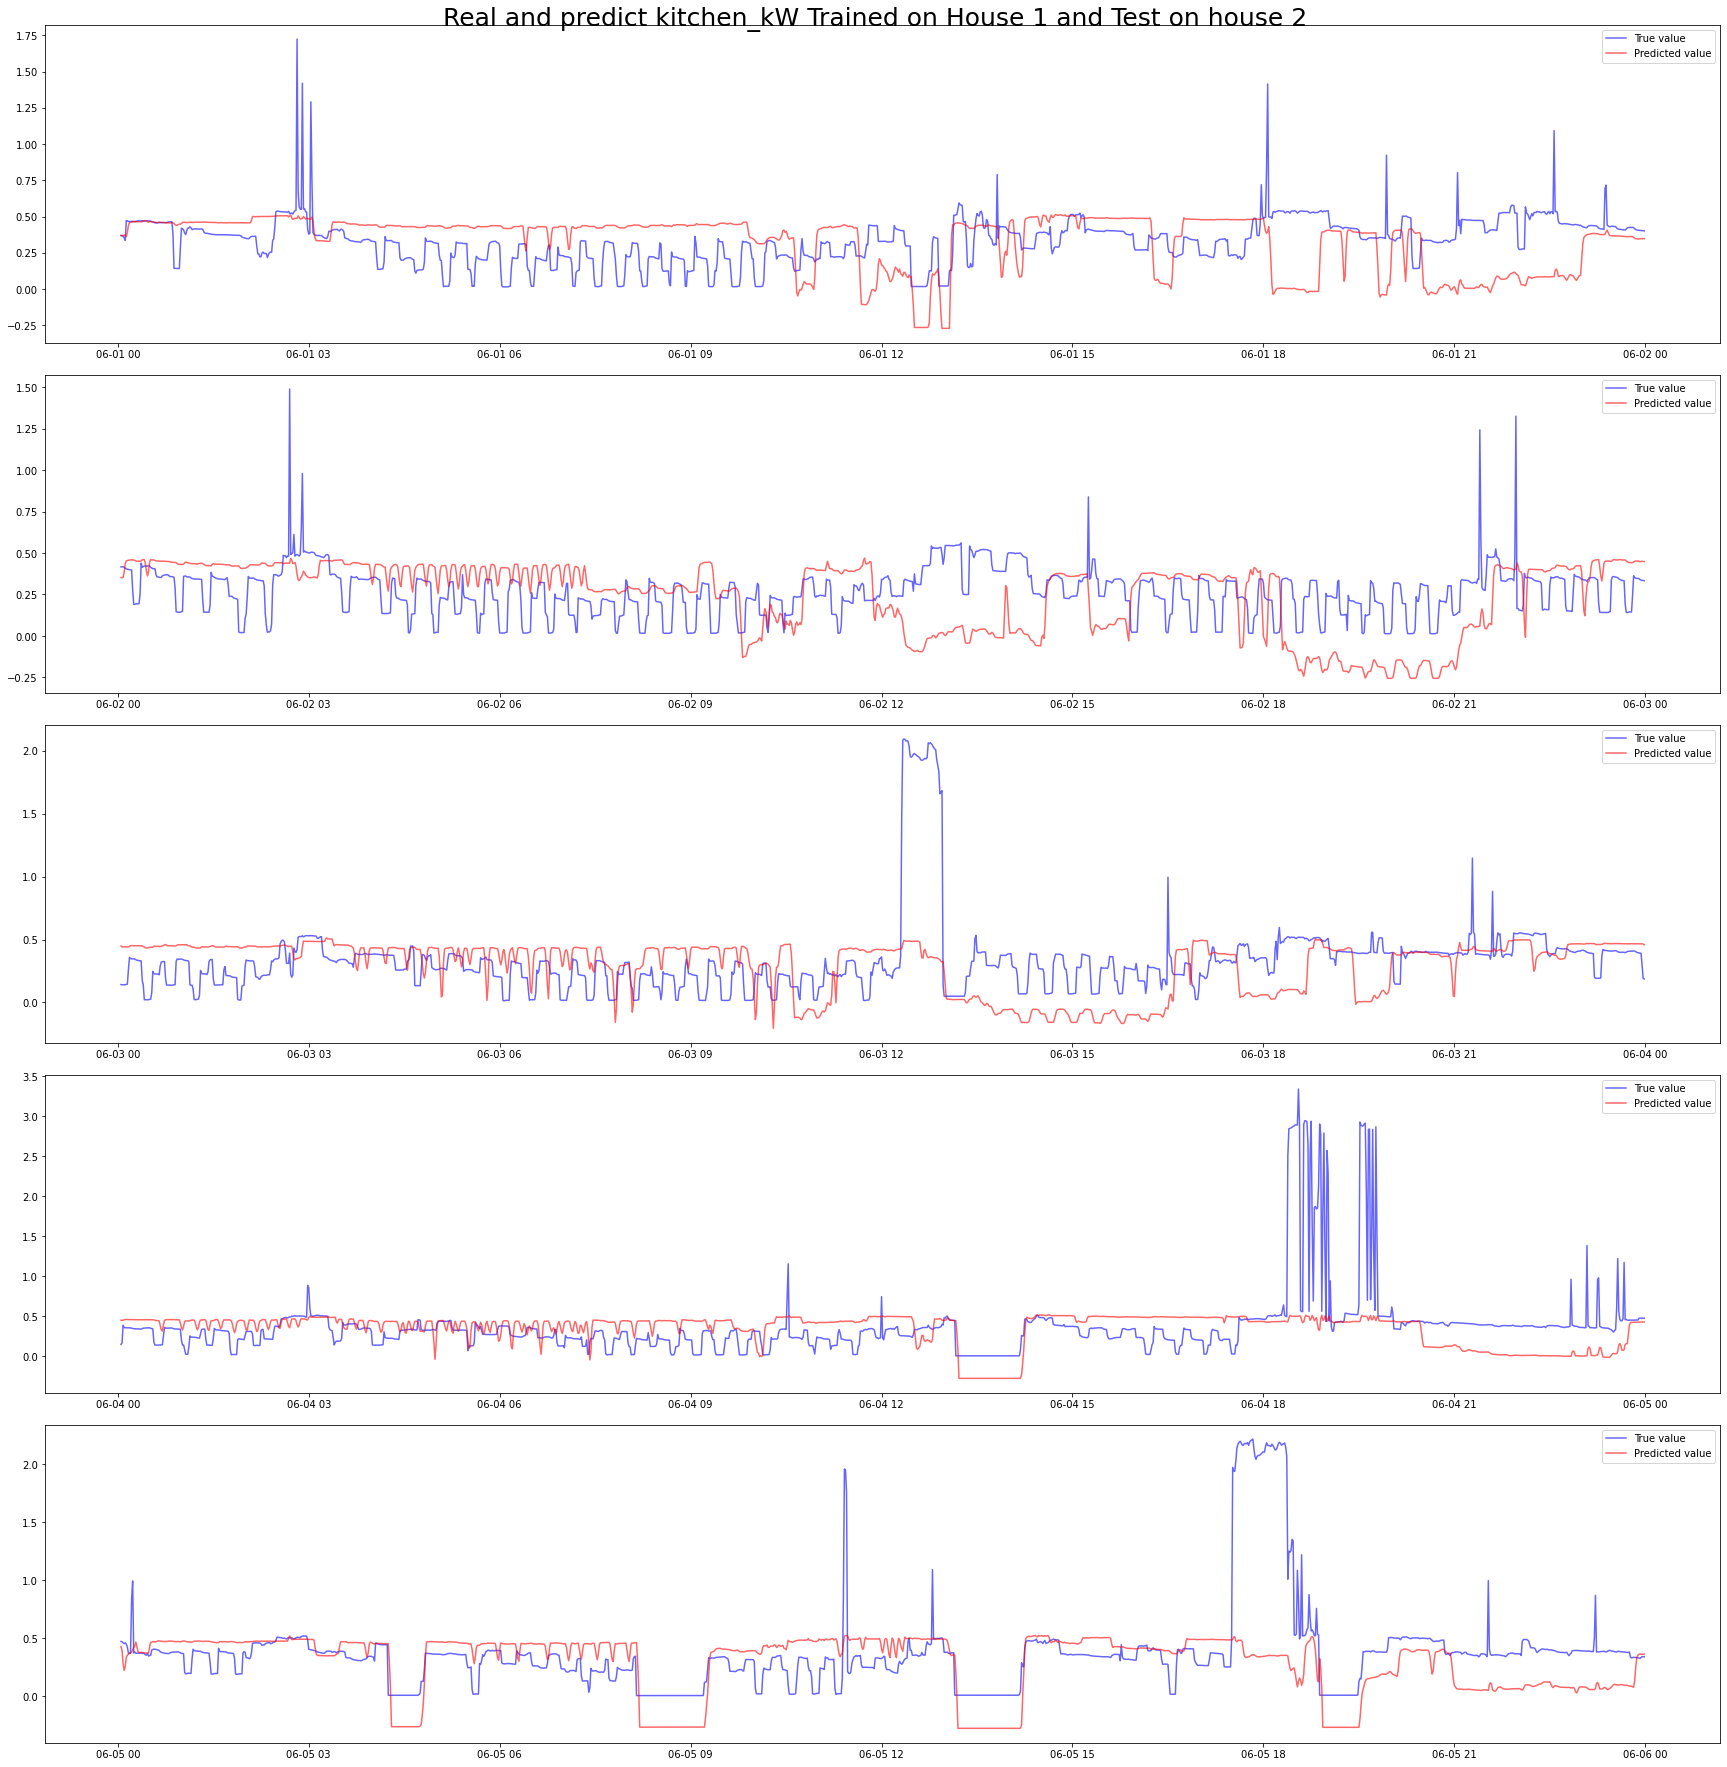

In [82]:
# Process Data
start = time.time()
X_2, y_2 = process_data(df[2], dates[2], train_inputs, output)
y_2 = y_2.reshape(-1)
print('Process data time: ', time.time() - start)
print(y_2.shape)

# Prediction
pred_lstm_h2 = model.predict(X_2).reshape(-1)
mse_loss_lstm_h2 = mse_loss(pred_lstm_h2, y_2)
mae_loss_lstm_h2 = mae_loss(pred_lstm_h2, y_2)
print('Mean square error on test set: ', mse_loss_lstm_h2)
print('Mean absolute error on the test set: ', mae_loss_lstm_h2)

# Print Results
plot_each_app(df[2], dates[2][:5], pred_lstm_h2, y_2,
              'Real and predict kitchen_kW Trained on House 1 and Test on house 2', look_back=3)